# MBTI Personality Classification Model Based on NLP

## Backgroud & Intro
The <b>Myers-Briggs Type Indicator (MBTI)</b> was constructed by Katharine Cook Briggs and her daughter Isabel Briggs Myers. This MBTI indicator aims to make intractable theories of psychological types understandable and useful in daily lives. Participants would get a general and objective view of their personalities by filling out a questionare that takes about 30 minutes. <br><br>

The MBTI has applications in diagnosing organisational issues, teamwork (particularly quality systems), communication, counselling, careers, strategic thinking, performance appraisal, leadership and stress management.  Nowadays, the MBTI test is used as a hiring strategy for 88% of the Fortune 500 companies. It helps HR officers in large companies to determine whether your personality is suitable for the postion you applied. <br><br>

Link for MBTI test (free): https://www.16personalities.com/free-personality-test<br>
Reference: 
1. __[Detailed explanation and more info about MBTI](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/)__
2. __[Understand MBTI](https://www.personalitypathways.com/MBTI_geyer-2.html#:~:text=The%20MBTI%20has%20applications%20in,change%20situations%20in%20different%20ways.)__

## Dataset
The dataset I will be using is scraped from __[PersonalityCafe Forum](https://www.personalitycafe.com/)__, including a sample size of more than 8,000. For each of the individual in this dataset, their type of MBTI personality and posts are recorded for further analysis.<br><br>
Link to Dataset: https://www.kaggle.com/datasets/datasnaek/mbti-type

In [1]:
import numpy as np
import pandas as pd # data processing

In [2]:
data=pd.read_csv('mbti_2.csv')
data.head()

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ


In [3]:
import matplotlib.pyplot as plt

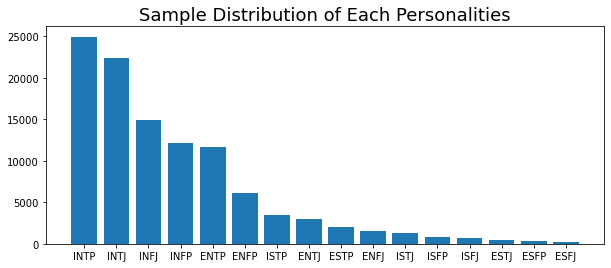

In [4]:
plt.figure(figsize=(10, 4))
plt.bar(data['type'].value_counts().index,data['type'].value_counts())
plt.title('Sample Distribution of Each Personalities',fontsize=18)
plt.show()

### Bootstraping
Since the dataset is highly unbalanced, **Bootstrapping** is used for regulating the number of samples in each classes

In [6]:
from tqdm.auto import tqdm

In [7]:
def boot(group):
    temp=data[data['type']==group]
    ind=np.random.choice(temp.index,size=2000,replace=True)
    return temp.loc[ind]

boots=[]
for i in tqdm(data['type'].unique()):
    boots.append(boot(i))

data=pd.concat(boots).reset_index(drop=True)
data

,posts,type
0,melanie doane seventeen ready murder one many ...,INTJ
1,rent house u husband sleep separate bedroom th...,INTJ
2,clear le likely stray actually talk problem so...,INTJ
3,school bully time try gain least social skill ...,INTJ
4,team apparently shop team west tdl fair enough...,INTJ
...,...,...
31995,fact people know shy advantage know people alw...,INFP
31996,ai précommandé sur parce que mon lecteur sur l...,INFP
31997,identify every single flaw fau basically tell ...,INFP
31998,yesterday well intend decision light informati...,INFP


## Data Processing & Tokenization

In [8]:
import re
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from tqdm.auto import tqdm

In [32]:
def text_processing(text):
    url_pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    #lowercase
    text=text.lower()
    #remove links
    text=re.sub(url_pattern,'LINK',text)        
    #remove non-alphanumeric except for apostrophes
    text=re.sub('[^a-zA-Z\s\']',' ',text)     
    return text

def tokenize(X):
    snow_stemmer = SnowballStemmer(language='english')
    out=[]
    stops = set(stopwords.words("english"))
    for text in tqdm(X):
        temp=text_processing(text).split()
        words=[snow_stemmer.stem(word) for word in temp if not word in stops]
        out.append(" ".join(words))
    return out


In [15]:
#data['words']=tokenize(data['posts'])
#data['word_count']=data['words'].apply(lambda x: len(x.split()))
encoder=LabelEncoder()
data['label']=encoder.fit_transform(data['type'])
data.head()

,posts,type,label
0,melanie doane seventeen ready murder one many ...,INTJ,10
1,rent house u husband sleep separate bedroom th...,INTJ,10
2,clear le likely stray actually talk problem so...,INTJ,10
3,school bully time try gain least social skill ...,INTJ,10
4,team apparently shop team west tdl fair enough...,INTJ,10


## WorldClound Visualization

In [9]:
from wordcloud import WordCloud

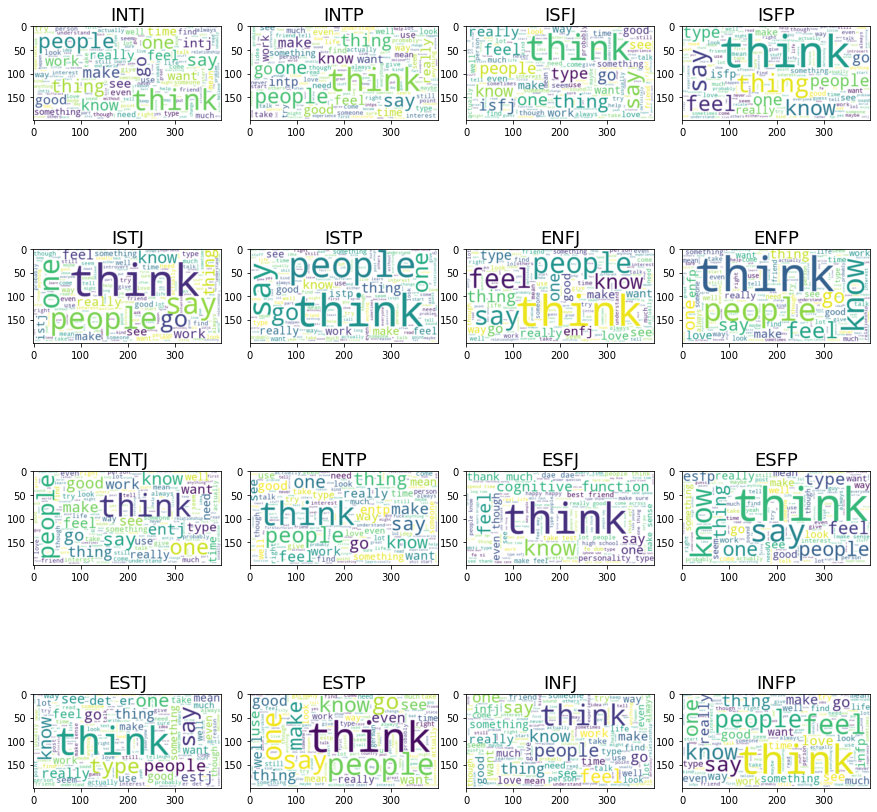

In [11]:
fig, ax = plt.subplots(16, sharex=True, figsize=(15,16))

count = 0
for i in tqdm(data['type'].unique()):
    temp = data[data['type'] == i]
    text= " ".join(list(temp['posts']))
    
    wordcloud = WordCloud(max_words=200,
                          background_color = 'White',
                          relative_scaling=1,
                          normalize_plurals=False).generate(text)
    
    plt.subplot(4,4,count+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i,fontsize=18)
    ax[count].axis("off")
    count+=1

plt.subplots_adjust(wspace=0.15, 
                    hspace=0.1)
plt.show()

## Vectorization

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)#reducing the number of features for complexity
X=vectorizer.fit_transform(data['posts']).todense()
y=data['label']

## Vectorization
reference: https://www.kaggle.com/code/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm/notebook

In [ ]:
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import multiprocessing

In [ ]:
%%time
w2v=Doc2Vec(transformed_X, 
            vector_size=300, 
            window=5, 
            min_count=10,
            max_vocab_size=20, 
            workers=4 )
w2v.save("doc2vec")

In [ ]:
class Vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):       
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in tqdm(X)
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
vectorizer=Vectorizer(w2v)
X=vectorizer.fit_transform(transformed_X)
X.shape
y=data['label']

In [18]:
# stratified train-test split for unbanlanced data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=data.type, 
                                                    random_state=1118)
print('Train X: ',X_train.shape)
print('Test X: ', X_test.shape)
print('Train Y: ',y_train.shape)
print('Test Y: ', y_test.shape)

Train X:  (22400, 500)
Test X:  (9600, 500)
Train Y:  (22400,)
Test Y:  (9600,)


## Model Selection

In [19]:
from sklearn.metrics import classification_report,r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score

### Logistic Model (Baseline)

$$p(y|X)=\frac{ e^{w^TX}}{1+e^{w^TX}} + C||w||_2$$

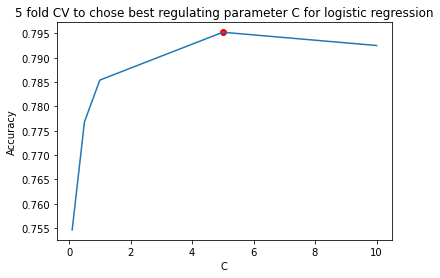

In [20]:
from sklearn.linear_model import LogisticRegression

c_logit=[0.1,0.5,1,5,10]
scores_logit=[]
for i in tqdm(c_logit):
    #weights=dict(zip(data['label'].value_counts(normalize=True)\
    #.index,data['label'].value_counts(normalize=True)))
    logit=LogisticRegression(max_iter=1000,C=i)
    logit.fit(X_train, y_train)
    scores_logit.append(np.mean(cross_val_score(logit, X_train, y_train, cv=5,scoring='accuracy')))
    
plt.plot(c_logit,scores_logit)
plt.title('5 fold CV to chose best regulating parameter C for logistic regression')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.scatter(c_logit[np.argmax(scores_logit)],scores_logit[np.argmax(scores_logit)],color='red')
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [22]:
logit_best=LogisticRegression(max_iter=1000,C=5)
logit_best.fit(X_train, y_train)
cm = confusion_matrix(y_test,
                      logit_best.predict(X_test))

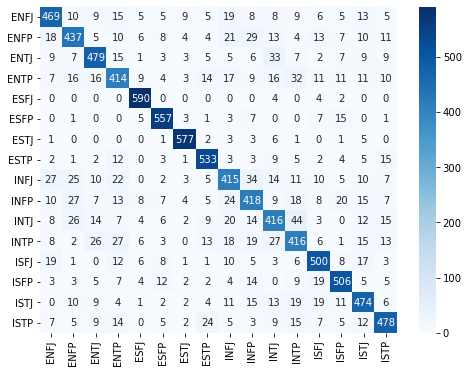

In [23]:
xticklabels=encoder.inverse_transform([i for i in range(16)])
yticklabels=encoder.inverse_transform([i for i in range(16)])
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap='Blues',
                xticklabels=xticklabels,
                yticklabels=yticklabels)

In [24]:
accuracy_score(y_test, logit_best.predict(X_test))

0.7998958333333334

The baseline Logistic Regression Model with regulating parameter C=5 gives an accuracy score of <b>0.81<b>

### Linear SVC

In [25]:
from sklearn.svm import LinearSVC

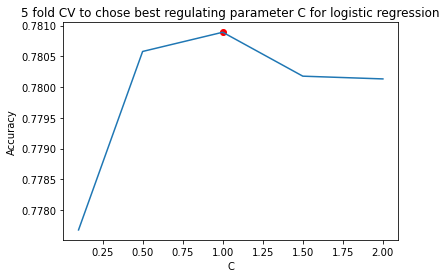

In [26]:
c_l_svc=[0.1,0.5,1,1.5,2]
scores_l_svc=[]
for i in tqdm(c_l_svc):
    linear_svc=LinearSVC(C=i)
    linear_svc.fit(X_train, y_train)
    scores_l_svc.append(np.mean(cross_val_score(linear_svc, X_train, y_train, cv=5,scoring='accuracy')))
    
plt.plot(c_l_svc,scores_l_svc)
plt.title('5 fold CV to chose best regulating parameter C for logistic regression')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.scatter(c_l_svc[np.argmax(scores_l_svc)],scores_l_svc[np.argmax(scores_l_svc)],color='red')
plt.show()

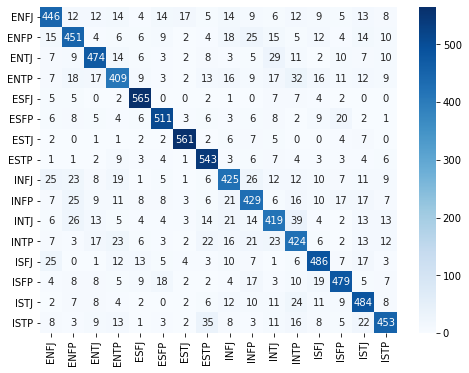

In [27]:
linear_svm_best=LinearSVC(C=0.15)
linear_svm_best.fit(X_train, y_train)
cm = confusion_matrix(y_test,
                      linear_svm_best.predict(X_test))

xticklabels=encoder.inverse_transform([i for i in range(16)])
yticklabels=encoder.inverse_transform([i for i in range(16)])
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap='Blues',
                xticklabels=xticklabels,
                yticklabels=yticklabels)

In [28]:
accuracy_score(y_test, linear_svm_best.predict(X_test))

0.7873958333333333

The Linear SVM model with regulating parameter C=0.15 gives an accuracy score of **0.69**